## Chapter 14 Use and Remove Seasonality



#### Seasonality in Time Series

Time series datasets can contain a seasonal component. This is a cycle that repeats over time, such as monthly or yearly.

A cycle structure in a time series may or may not be seasonal. If it consistently repeats at the same frequency, it is seasonal, otherwise it is not seasonal and is called a cycle.

Types of Seasonality: time of day, daily, weekly, monthly, yearly.

As such, identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at diﬀerent scales and with the addition of trend lines.

Once seasonality is identified, it can be modeled. The model of seasonality can be removed from the time series. This process is called **Seasonal Adjustment, or Deseasonalizing**. A time series where the seasonal component has been removed is called seasonal stationary. A time series with a clear seasonal component is referred to as non-stationary.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
series = pd.read_csv('data/daily-minimum-temperatures.csv', index_col=0, parse_dates=True)
series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


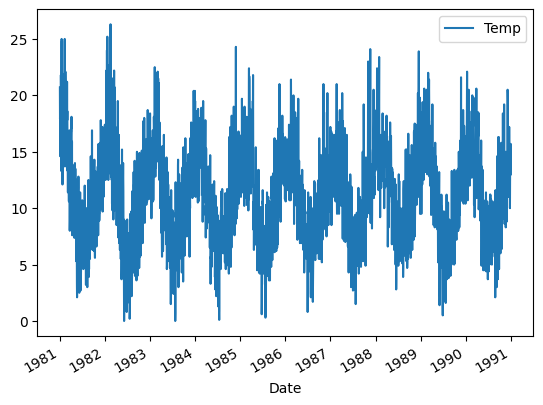

In [3]:
series.plot()
plt.show()

#### Seasonal Adjustment with Differencing

A simple way to correct for a seasonal component is to use diﬀerencing. If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week.

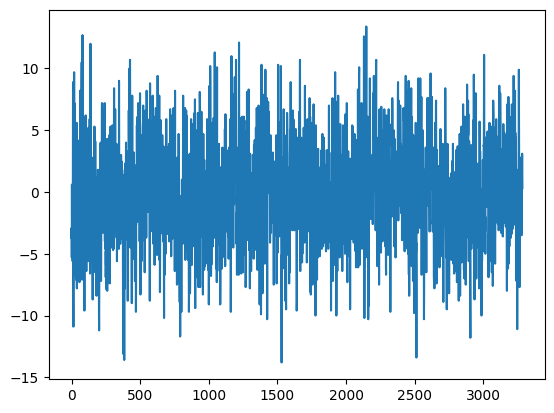

In [4]:
# deseasonalize a time series using differencing
X = series['Temp'].values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
  value = X[i] - X[i - days_in_year]
  diff.append(value)
plt.plot(diff)
plt.show()

There are two leap years in our dataset (1984 and 1988). They are not explicitly handled; this means that observations in March 1984 onwards the oﬀset are wrong by one day, and after March 1988, the oﬀsets are wrong by two days. One option is to update the code example to be leap-day aware.

Another option is to consider that the temperature within any given period of the year is probably stable. Perhaps over a few weeks. We can shortcut this idea and consider all temperatures within a calendar month to be stable. An improved model may be to subtract the average temperature from the same calendar month in the previous year, rather than the same day. We can start oﬀ by resampling the dataset to a monthly average minimum temperature.

                 Temp
Date                 
1981-01-31  17.712903
1981-02-28  17.678571
1981-03-31  13.500000
1981-04-30  12.356667
1981-05-31   9.490323
1981-06-30   7.306667
1981-07-31   7.577419
1981-08-31   7.238710
1981-09-30  10.143333
1981-10-31  10.087097
1981-11-30  11.890000
1981-12-31  13.680645
1982-01-31  16.567742


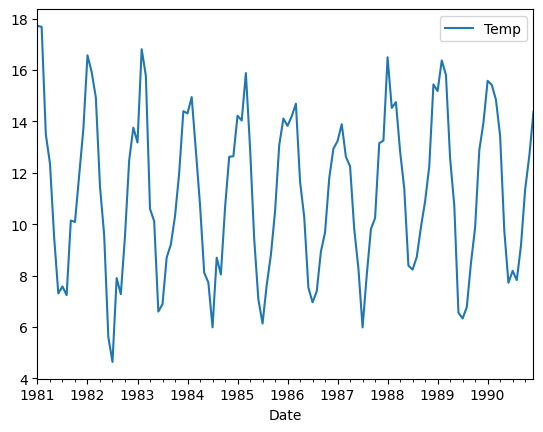

In [7]:
# calculate and plot monthly average
resample = series.resample('ME')
monthly_mean = resample.mean()
print(monthly_mean.head(13))
monthly_mean.plot()
plt.show()

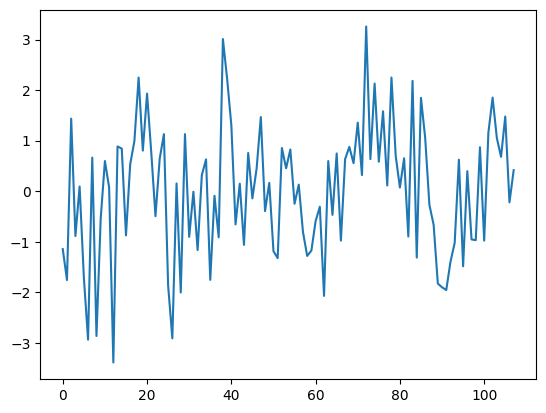

In [15]:
# deseasonalize monthly data by differencing
diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
  value = monthly_mean['Temp'].values[i] - monthly_mean['Temp'].values[i - months_in_year]
  diff.append(value)
plt.plot(diff)
plt.show()

Next, we can use the monthly average minimum temperatures from the same month in the previous year to adjust the daily minimum temperature dataset. Again, we just skip the first year of data, but the correction using the monthly rather than the daily data may be a more stable approach.

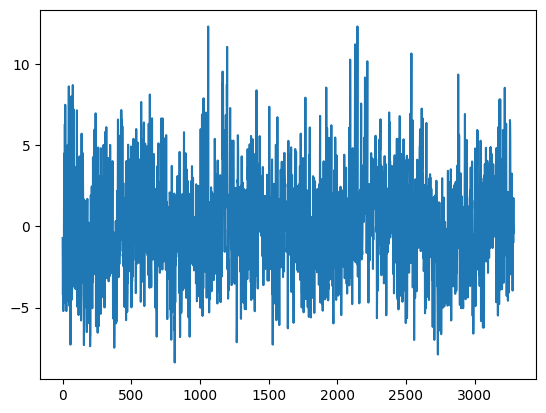

In [42]:
df = pd.DataFrame(series['Temp'].values, columns=['Temp'])
df['Date'] = series.index
df['month_str_last_year'] = None

for i in range(len(df)):
  year_month_str = str(series.index[i].year) + '-' + str(series.index[i].month)
  df.loc[i, 'month_str_last_year'] = year_month_str

X = series['Temp'].values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
  month_str_last_year = str(series.index[i].year-1) + '-' + str(series.index[i].month)
  month_mean_last_year = df[df['month_str_last_year'] == month_str_last_year]['Temp'].mean()
  value = X[i] - month_mean_last_year
  diff.append(value)

plt.plot(diff)
plt.show()

#### Seasonal Adjustment with Modeling

We can model the seasonal component directly, then subtract it from the observations. The seasonal component in a given time series is likely a sine wave over a generally fixed period and amplitude. This can be approximated easily using a *curve-fitting* method.

In the case of the temperature data, the time index would be *the day of the year*. We can then estimate the seasonal component for the day of the year for any historical observations or any new observations in the future. The curve can then be used as a new input for modeling with supervised learning algorithms, or subtracted from observations to create a seasonally adjusted
series.

For consistent sine wave-like seasonality, a 4th order or 5th order polynomial will be suﬃcient.

Coefficients: [-1.17308000e-08  9.30253946e-06 -2.15977594e-03  1.19147966e-01
  1.38980178e+01]


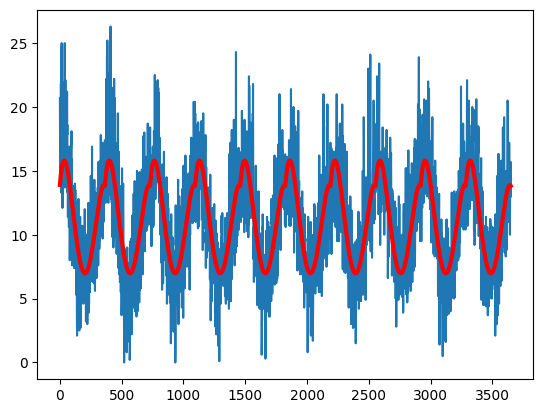

In [57]:
# model seasonality with a polynomial model
# fit polynomial
X = [i%365 for i in range(len(series))]
y = series['Temp'].values
degree = 4
coef = np.polyfit(X, y, degree)
print(f'Coefficients: {coef}')

# create curve
curve = list()
for i in range(len(X)):
  value = coef[-1]
  for d in range(degree):
    value += X[i] ** (degree-d) * coef[d]
  curve.append(value)
plt.plot(y)
plt.plot(curve, color='red', linewidth=3)
plt.show()

One limitation of this model is that it does not take into account of leap days, adding small oﬀset noise that could easily be corrected with an update to the approach. For example, we could just remove the two February 29 observations from the dataset when creating the seasonal model.

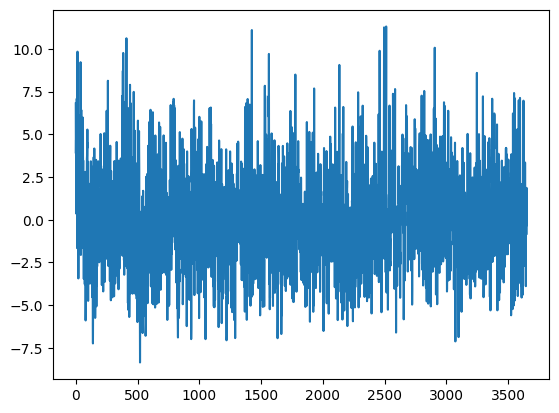

In [59]:
# deseasonalize by differencing with a polynomial model
# create seasonally adjusted
values = series['Temp'].values
diff = list()
for i in range(len(values)):
  value = values[i] - curve[i]
  diff.append(value)
plt.plot(diff)
plt.show()